何時選擇 XGBoost 或 LightGBM？
如果你處理的數據集比較小或中等，且關心穩定性和可解釋性，XGBoost 是一個不錯的選擇。
如果你處理的是 大數據集 或者需要更快的訓練速度，並且你的特徵數量很高，則 LightGBM 會是更好的選擇，特別是在大規模數據的場景中。

In [29]:
!pip install lightgbm


==== Training with All Features ====
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

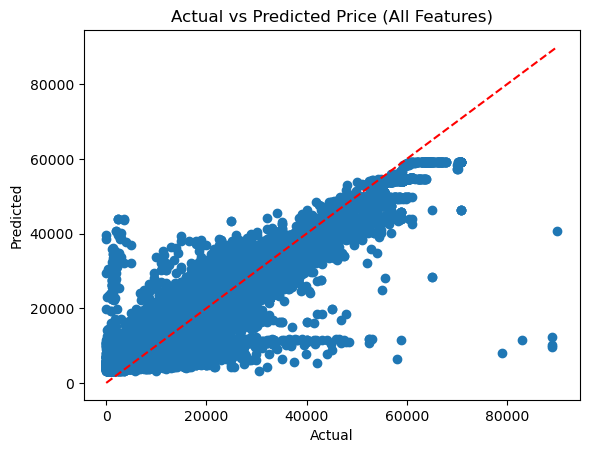

MAE: 2500.7280
MSE: 14753328.1248
R^2: 0.9240

==== Training with Selected Features ====
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM

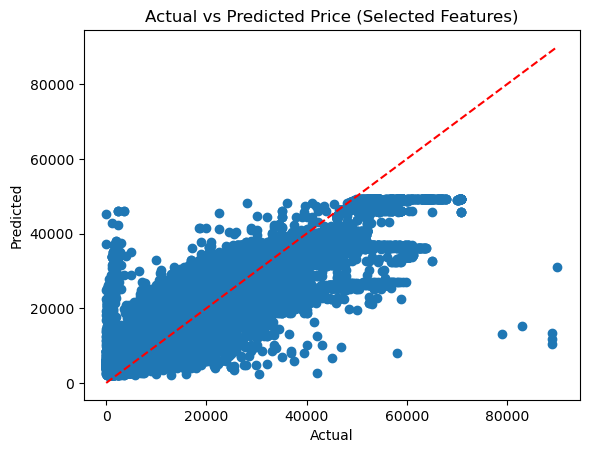

MAE: 4245.0316
MSE: 34357003.5072
R^2: 0.8231

==== Final Results Comparison ====
         Feature Set          MAE           MSE       R^2
0       All Features  2500.728004  1.475333e+07  0.924027
1  Selected Features  4245.031583  3.435700e+07  0.823076


In [2]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import log_evaluation, early_stopping

# 讀取資料
file_path = 'final.json'  # 請替換為你的檔案路徑
data = pd.read_json(file_path)

# 類別欄位和數值欄位
categorical_cols = ['廠商', '型號', '顏色', '地區','福利品', '配件', '全新','記憶體',]
numerical_cols = [ '容量', '電池健康度', '日期', '上市日', '資料抓取日','保固時長', 
                     '抓取日建議售價', '上市日建議售價'] #不含金額,'抓取日建議售價','上市日建議售價'

# 只保留資料中實際存在的欄位
categorical_cols = [col for col in categorical_cols if col in data.columns]
numerical_cols = [col for col in numerical_cols if col in data.columns]

# 處理日期型欄位，轉換為時間戳記
date_cols = ['日期', '上市日', '資料抓取日']
for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce').astype('int64') // 10**9  # 轉換為 Unix 時間戳記（秒）

# 使用 LabelEncoder 進行類別型特徵編碼
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 定義所有特徵與選擇特徵
all_features = categorical_cols + numerical_cols
selected_features = [col for col in ['廠商', '型號', '容量', '電池健康度', '日期', '上市日', '資料抓取日'] if col in data.columns]

# 儲存結果
results = []

# 迭代兩種特徵選擇策略
for feature_set, feature_name in zip([all_features, selected_features], ["All Features", "Selected Features"]):
    print(f'\n==== Training with {feature_name} ====')
    
    # 設定 X, y
    X = data[feature_set]
    y = data['金額']
    
    # 拆分訓練與測試集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 設定 LightGBM 模型
    model = lgb.LGBMRegressor(
    learning_rate=0.01,   # 提高學習率，加快收斂
    n_estimators=300,     # 降低樹的數量，避免過擬合
    max_depth=4,          # 降低樹的深度，提高泛化能力
    num_leaves=10,        # 控制葉節點數量，適當降低過擬合
    min_gain_to_split=0.5, # 增加最小增益分裂，避免過多無效分裂
    min_data_in_leaf=300,  # 增加每葉最小樣本數，降低過擬合風險
    lambda_l1=10,         # L1 正則化，防止過擬合
    lambda_l2=10,         # L2 正則化，防止過擬合
    random_state=42       # 固定隨機數，確保可復現
    )
    # 訓練模型
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[log_evaluation(100), early_stopping(50)]  # 每 100 步顯示進度，50 步無改善則停止
    )
    
    # 預測
    y_pred = model.predict(X_test)
    
    # 評估模型
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({
        "Feature Set": feature_name,
        "MAE": mae,
        "MSE": mse,
        "R^2": r2
    })
    
    # 視覺化結果
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Price ({feature_name})')
    plt.show()
    
    # 輸出結果
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R^2: {r2:.4f}')

# 顯示最終結果
results_df = pd.DataFrame(results)
print('\n==== Final Results Comparison ====')
print(results_df)


# print("Models stored:", models.keys())  


# def predict_price(model_type, 廠商, 型號, 容量, 電池健康度):
#     print("Available models:", models.keys())  # 檢查是否有模型
    
#     if model_type not in models:
#         raise ValueError(f"Invalid model type: {model_type}. Choose 'All Features' or 'Selected Features'.")
    
#     model = models[model_type]
    
#     input_data = pd.DataFrame([[廠商, 型號, 容量, 電池健康度]], columns=['廠商', '型號', '容量', '電池健康度'])
    
#     # 進行 Label Encoding
#     for col in ['廠商', '型號']:
#         if col in label_encoders:
#             input_data[col] = label_encoders[col].transform(input_data[col])
    
#     predicted_price = model.predict(input_data)[0]
#     std_dev = data['金額'].std()  # 修正變數來源，避免 NameError
#     lower_bound = predicted_price - std_dev
#     upper_bound = predicted_price + std_dev
    
#     return predicted_price, lower_bound, upper_bound

In [5]:
X.columns

Index(['廠商', '型號', '容量', '電池健康度', '日期', '上市日'], dtype='object')

In [3]:
import json
import numpy as np

# 自訂 JSON 序列化函式
def json_converter(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")

# 取得原始特徵重要性
importance = model.feature_importances_
normalized_importance = importance / importance.sum()

# 將結果儲存成 JSON 檔案
results = {
    "MAE": mae,
    "MSE": mse,
    "R^2": r2,
    "Feature Importance": dict(zip(X.columns, normalized_importance))
}

# 根據模型名稱指定檔案名稱
model_name = "lightgbm"  # 換成 lightgbm 或 xgboost random_forest
file_name = f"{model_name}_results.json"

# 儲存為 JSON
with open(file_name, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4, default=json_converter)

print(f"結果已儲存至 {file_name}")


結果已儲存至 lightgbm_results.json


In [39]:
import pandas as pd
import numpy as np

# 計算殘差標準差 (假設已經訓練過模型並有 y_test 和 y_pred)
residual_std = np.std(y_test - y_pred)

# 新的輸入資料
new_input = {
    '廠商': ['apple'],
    '型號': ['iphone 13 pro max'],
    '容量': [128],
    '電池健康度': [80]
}
new_data = pd.DataFrame(new_input)

# 補全訓練時所用但預測資料中缺少的欄位
new_data['日期'] = pd.to_datetime('2025-03-03').value // 10**9   # 例如使用資料抓取日
new_data['上市日'] = pd.to_datetime('2021-06-16').value // 10**9   # 使用上市日

# 對類別欄位進行 label encoding（必須使用訓練時存好的 encoder）
new_data['廠商'] = label_encoders['廠商'].transform(new_data['廠商'])
new_data['型號'] = label_encoders['型號'].transform(new_data['型號'])

# 選擇與訓練時相同的特徵（此處使用「Selected Features」策略）
selected_features = ['廠商', '型號', '容量', '電池健康度', '日期', '上市日']

# 確保預測資料只包含訓練時的特徵
new_data = new_data[selected_features]

# 使用訓練好的模型進行預測
predicted_price = model.predict(new_data)[0]

# 加上正負一個標準差範圍
lower_bound = predicted_price - residual_std
upper_bound = predicted_price + residual_std

# 印出結果，包括標準差
print(f"殘差標準差: {residual_std:.2f}")
print(f"預測的金額: {predicted_price:.2f}")
print(f"金額範圍: {lower_bound:.2f} ~ {upper_bound:.2f}")




[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
殘差標準差: 5680.15
預測的金額: 9594.56
金額範圍: 3914.41 ~ 15274.72


剔除極端值的lightGBN

極端值範圍：低於 -24550.00 或高於 59530.00
原始資料筆數：273546, 篩選後資料筆數：272270


C:\Users\Robby1206\AppData\Local\Temp\ipykernel_16072\1295312127.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col])
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_16072\1295312127.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col])
C:\Users\Robby1206\AppData\Local\Temp\ipykernel_16072\1295312127.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra


==== Training with All Features ====
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

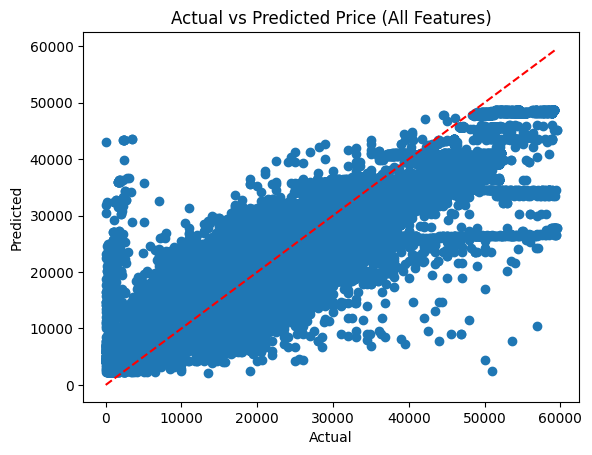

MAE: 4074.5937
MSE: 30994057.7857
R^2: 0.8323

==== Training with Selected Features ====
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM

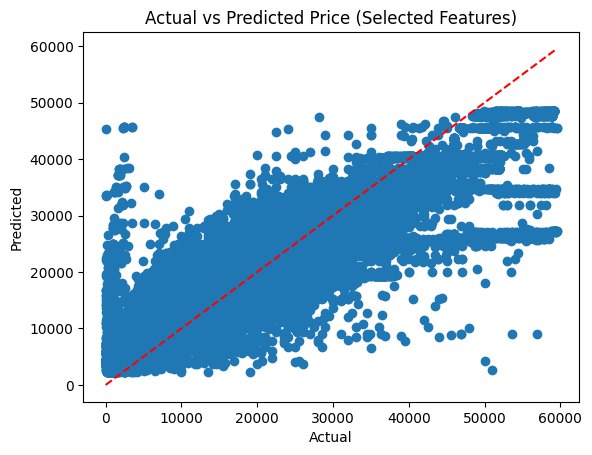

MAE: 4142.0393
MSE: 32265129.6754
R^2: 0.8254

==== Final Results Comparison ====
         Feature Set          MAE           MSE       R^2
0       All Features  4074.593726  3.099406e+07  0.832320
1  Selected Features  4142.039324  3.226513e+07  0.825444


In [36]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import log_evaluation, early_stopping

# 讀取資料
file_path = 'final.json'  # 請替換為你的檔案路徑
data = pd.read_json(file_path)

# 類別欄位和數值欄位
categorical_cols = ['廠商', '型號', '顏色', '地區', '福利品', '配件', '全新']
numerical_cols = ['容量', '電池健康度', '日期', '上市日', '資料抓取日', '保固時長']

# 只保留資料中實際存在的欄位
categorical_cols = [col for col in categorical_cols if col in data.columns]
numerical_cols = [col for col in numerical_cols if col in data.columns]

# 處理日期型欄位，轉換為時間戳記
date_cols = ['日期', '上市日', '資料抓取日']
for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce').astype('int64') // 10**9

# 使用 IQR 方法剔除極端值
Q1 = data['金額'].quantile(0.25)
Q3 = data['金額'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"極端值範圍：低於 {lower_bound:.2f} 或高於 {upper_bound:.2f}")

# 篩選掉極端值
filtered_data = data[(data['金額'] >= lower_bound) & (data['金額'] <= upper_bound)]
print(f"原始資料筆數：{len(data)}, 篩選後資料筆數：{len(filtered_data)}")

# 使用 LabelEncoder 進行類別型特徵編碼
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    filtered_data[col] = le.fit_transform(filtered_data[col])
    label_encoders[col] = le

# 定義所有特徵與選擇特徵
all_features = categorical_cols + numerical_cols
selected_features = [col for col in ['廠商', '型號', '容量', '電池健康度', '日期', '上市日'] if col in filtered_data.columns]

# 儲存結果
results = []

# 迭代兩種特徵選擇策略
for feature_set, feature_name in zip([all_features, selected_features], ["All Features", "Selected Features"]):
    print(f'\n==== Training with {feature_name} ====')
    
    # 設定 X, y
    X = filtered_data[feature_set]
    y = filtered_data['金額']
    
    # 拆分訓練與測試集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 設定 LightGBM 模型
    model = lgb.LGBMRegressor(
    learning_rate=0.01,   # 提高學習率，加快收斂
    n_estimators=300,     # 降低樹的數量，避免過擬合
    max_depth=4,          # 降低樹的深度，提高泛化能力
    num_leaves=10,        # 控制葉節點數量，適當降低過擬合
    min_gain_to_split=0.5, # 增加最小增益分裂，避免過多無效分裂
    min_data_in_leaf=300,  # 增加每葉最小樣本數，降低過擬合風險
    lambda_l1=10,         # L1 正則化，防止過擬合
    lambda_l2=10,         # L2 正則化，防止過擬合
    random_state=42       # 固定隨機數，確保可復現
    )


    # 訓練模型
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[log_evaluation(100), early_stopping(50)]
    )
    
    # 預測
    y_pred = model.predict(X_test)
    
    # 評估模型
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({
        "Feature Set": feature_name,
        "MAE": mae,
        "MSE": mse,
        "R^2": r2
    })
    
    # 視覺化結果
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Price ({feature_name})')
    plt.show()
    
    # 輸出結果
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R^2: {r2:.4f}')

# 顯示最終結果
results_df = pd.DataFrame(results)
print('\n==== Final Results Comparison ====')
print(results_df)


In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(X)  # 在X矩陣中加入常數項
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


MissingDataError: exog contains inf or nans

In [38]:
import pandas as pd
import numpy as np

# 計算殘差標準差 (假設已經訓練過模型並有 y_test 和 y_pred)
residual_std = np.std(y_test - y_pred)

# 新的輸入資料
new_input = {
    '廠商': ['apple'],
    '型號': ['iphone 13 pro max'],
    '容量': [128],
    '電池健康度': [80]
}
new_data = pd.DataFrame(new_input)

# 補全訓練時所用但預測資料中缺少的欄位
new_data['日期'] = pd.to_datetime('2025-03-03').value // 10**9   # 例如使用資料抓取日
new_data['上市日'] = pd.to_datetime('2021-06-16').value // 10**9   # 使用上市日

# 對類別欄位進行 label encoding（必須使用訓練時存好的 encoder）
new_data['廠商'] = label_encoders['廠商'].transform(new_data['廠商'])
new_data['型號'] = label_encoders['型號'].transform(new_data['型號'])

# 選擇與訓練時相同的特徵（此處使用「Selected Features」策略）
selected_features = ['廠商', '型號', '容量', '電池健康度', '日期', '上市日']

# 確保預測資料只包含訓練時的特徵
new_data = new_data[selected_features]

# 使用訓練好的模型進行預測
predicted_price = model.predict(new_data)[0]

# 加上正負一個標準差範圍
lower_bound = predicted_price - residual_std
upper_bound = predicted_price + residual_std

# 印出結果，包括標準差
print(f"殘差標準差: {residual_std:.2f}")
print(f"預測的金額: {predicted_price:.2f}")
print(f"金額範圍: {lower_bound:.2f} ~ {upper_bound:.2f}")




[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
殘差標準差: 5680.15
預測的金額: 9594.56
金額範圍: 3914.41 ~ 15274.72


In [34]:
print(f"目前資料筆數：{len(data)}")


目前資料筆數：273546


In [ ]:
print("All Features:", all_features)
print("Selected Features:", selected_features)

All Features: ['廠商', '型號', '顏色', '地區', '福利品', '配件', '全新', '容量', '電池健康度', '日期', '上市日', '資料抓取日', '保固時長']
Selected Features: ['廠商', '型號', '容量', '電池健康度', '日期', '上市日']
